In [2]:
import pandas as pd
from pathlib import Path
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import osmnx as ox
from shapely.geometry import Polygon

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
data_dir = Path("/data/pgcasado/datasets/acute/")
df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)

mask = (df['timestamp'] > '2023-06-21') & (df['timestamp'] <= '2023-12-31') & (df["station_name"] == "0QRDKC2R03J32P") #& (df["longitude"] < 7) & (df["longitude"] > 2)
df = df[mask]

/tmp/ipykernel_835614/2983530556.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


In [4]:
# option 1: by cities
"""
cities = ["Brussels", "Anderlecht", "Schaarbeek", "Steenokkerzeel", "Zaventem", "Machelen"]

tags = {"building": ["public", "church", "palace", "chapel", "university", "hospital", "roof", "government", "stadium", "historic"]}
dfx = pd.concat(
    ox.features.features_from_place(city, tags=tags)
    for city in cities
)

dfx.dropna(subset=['name'], inplace=True)
dfx['longitude'] = dfx['geometry'].apply(lambda x: x.centroid.coords.xy[0][0])
dfx['latitude']  = dfx['geometry'].apply(lambda x: x.centroid.coords.xy[1][0])
dfx[["name", "latitude", "longitude", "building"]].droplevel(level=0)
"""

'\ncities = ["Brussels", "Anderlecht", "Schaarbeek", "Steenokkerzeel", "Zaventem", "Machelen"]\n\ntags = {"building": ["public", "church", "palace", "chapel", "university", "hospital", "roof", "government", "stadium", "historic"]}\ndfx = pd.concat(\n    ox.features.features_from_place(city, tags=tags)\n    for city in cities\n)\n\ndfx.dropna(subset=[\'name\'], inplace=True)\ndfx[\'longitude\'] = dfx[\'geometry\'].apply(lambda x: x.centroid.coords.xy[0][0])\ndfx[\'latitude\']  = dfx[\'geometry\'].apply(lambda x: x.centroid.coords.xy[1][0])\ndfx[["name", "latitude", "longitude", "building"]].droplevel(level=0)\n'

/tmp/ipykernel_835614/858690015.py:21: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/data/pgcasado/envs/daddy/lib/python3.11/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/data/pgcasado/envs/daddy/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/data/pgcasado/envs/daddy/lib/python3.11/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will b

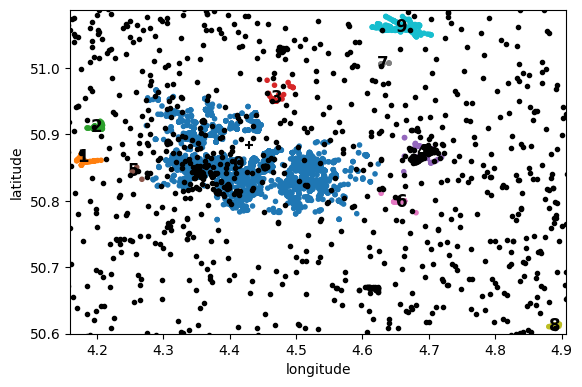

In [5]:
# Filter by altitude
altitude_limit = 150
mask_alt = (df["altitude"] > altitude_limit)
df = df.loc[mask_alt]

# Define your latitude and longitude limits
lat_min, lat_max = df["latitude"].min(), df["latitude"].max()
lon_min, lon_max = df["longitude"].min(), df["longitude"].max()

# Create a square polygon
polygon = Polygon([(lon_min, lat_min), (lon_min, lat_max), (lon_max, lat_max), (lon_max, lat_min)])

# Create the dataframe of the place of interest
tags = {"building": ["church", "palace", "chapel", "university", "hospital", "government", "stadium", "historic"]}
dfx = ox.features.features_from_polygon(polygon, tags=tags)
dfx.dropna(subset=['name'], inplace=True)
dfx['longitude'] = dfx['geometry'].apply(lambda x: x.centroid.coords.xy[0][0])
dfx['latitude']  = dfx['geometry'].apply(lambda x: x.centroid.coords.xy[1][0])

# read the shapefile for the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# plot the world map
world.plot(color='white', edgecolor='black')

# create a DBSCAN object
dbscan = DBSCAN(eps=0.025, min_samples=17) # 0.025, 30

# fit the model to the data
dbscan.fit(df[['latitude', 'longitude']])
df["cluster"] = dbscan.labels_

dfn = df[df["cluster"] >= 0]
labels = np.delete(dbscan.labels_, np.where(dbscan.labels_ == -1))

# plot the clusters
plt.scatter(dfn['longitude'], dfn['latitude'], c=labels, cmap = "tab10", marker=".")

# add the cluster labels to the plot
for i in range(len(np.unique(labels))):
    x = np.mean(dfn[dfn["cluster"] == i]['longitude'])
    y = np.mean(dfn[dfn["cluster"] == i]['latitude'])
    plt.annotate(str(i), xy=(x, y), color='black', fontsize=12, fontweight='bold', ha='center', va='center')

# set the x and y limits of the plot
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.xlim(dfn["longitude"].min()-0.01, dfn["longitude"].max()+0.01)
plt.ylim(dfn["latitude"].min()-0.01, dfn["latitude"].max()+0.01)

plt.scatter(df["station_longitude"].iloc[0], df["station_latitude"].iloc[0], marker="+", color="black")
plt.scatter(dfx["longitude"].values, dfx["latitude"].values, marker=".", color = "black")

# show the plot
plt.show()

In [8]:
from geopy import distance
# define a function to calculate the distance between two points
# revisar en que medidas están las alturas!!!!!!!
def calculate_distance(row):
    home_coords = (row['home_lat'], row['home_lon'], row['home_height'])
    point_coords = (row['latitude'], row['longitude'], row['altitude'])
    flat_distance = distance.distance(home_coords[:2], point_coords[:2]).m # distancia calculada en metros
    euclidian_distance = np.sqrt(flat_distance**2 + (point_coords[2] - home_coords[2])**2)
    return euclidian_distance

# apply the function to each row of the dataframe
df['distance'] = df.apply(calculate_distance, axis=1)

In [6]:
import ipywidgets as widgets
from IPython.display import display

# Create sliders
altitude_limit_slider = widgets.IntSlider(min=0, max=500, step=1, description='Altitude Limit:')
eps_slider = widgets.FloatSlider(min=0.01, max=1, step=0.01, description='EPS:')
min_samples_slider = widgets.IntSlider(min=1, max=50, step=1, description='Min Samples:')

# Display sliders
display(altitude_limit_slider, eps_slider, min_samples_slider)

def update_map(altitude_limit, eps, min_samples):
    # Filter by altitude
    mask_alt = (df["altitude"] > altitude_limit)
    df = df.loc[mask_alt]

    # Define your latitude and longitude limits
    lat_min, lat_max = df["latitude"].min(), df["latitude"].max()
    lon_min, lon_max = df["longitude"].min(), df["longitude"].max()

    # Create a square polygon
    polygon = Polygon([(lon_min, lat_min), (lon_min, lat_max), (lon_max, lat_max), (lon_max, lat_min)])

    # Create the dataframe of the place of interest
    tags = {"building": ["church", "palace", "chapel", "university", "hospital", "government", "stadium", "historic"]}
    dfx = ox.features.features_from_polygon(polygon, tags=tags)
    dfx.dropna(subset=['name'], inplace=True)
    dfx['longitude'] = dfx['geometry'].apply(lambda x: x.centroid.coords.xy[0][0])
    dfx['latitude']  = dfx['geometry'].apply(lambda x: x.centroid.coords.xy[1][0])

    # read the shapefile for the world map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # plot the world map
    world.plot(color='white', edgecolor='black')

    # create a DBSCAN object
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # fit the model to the data
    dbscan.fit(df[['latitude', 'longitude']])
    df["cluster"] = dbscan.labels_

    dfn = df[df["cluster"] >= 0]
    labels = np.delete(dbscan.labels_, np.where(dbscan.labels_ == -1))

    # plot the clusters
    plt.scatter(dfn['longitude'], dfn['latitude'], c=labels, cmap = "tab10", marker=".")

    # add the cluster labels to the plot
    for i in range(len(np.unique(labels))):
        x = np.mean(dfn[dfn["cluster"] == i]['longitude'])
        y = np.mean(dfn[dfn["cluster"] == i]['latitude'])
        plt.annotate(str(i), xy=(x, y), color='black', fontsize=12, fontweight='bold', ha='center', va='center')

    # set the x and y limits of the plot
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.xlim(dfn["longitude"].min()-0.01, dfn["longitude"].max()+0.01)
    plt.ylim(dfn["latitude"].min()-0.01, dfn["latitude"].max()+0.01)

    plt.scatter(df["station_longitude"].iloc[0], df["station_latitude"].iloc[0], marker="+", color="black")
    plt.scatter(dfx["longitude"].values, dfx["latitude"].values, marker=".", color = "black")

    # show the plot
    plt.show()

# Call the function with slider values
widgets.interactive(update_map, altitude_limit=altitude_limit_slider, eps=eps_slider, min_samples=min_samples_slider)


/data/pgcasado/envs/daddy/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


IntSlider(value=0, description='Altitude Limit:', max=500)

FloatSlider(value=0.01, description='EPS:', max=1.0, min=0.01, step=0.01)

IntSlider(value=1, description='Min Samples:', max=50, min=1)

interactive(children=(IntSlider(value=0, description='Altitude Limit:', max=500), FloatSlider(value=0.01, desc…

In [9]:
cluster_df = pd.DataFrame()
for i in range(df["cluster"].max()):
    df_i = df[df["cluster"]==i]
    cluster_df.loc[i, "max_altitude"] = df_i["altitude"].max()
    cluster_df.loc[i, ">100"] = sum(df_i["altitude"] > 100)
    cluster_df.loc[i, "max_distance"] = df_i["distance"].max()

cluster_df[">100"] = cluster_df[">100"].astype("int")
cluster_df

,max_altitude,>100,max_distance
0,591.0,11394,3417.779584
1,521.0,97,2000.913084
2,425.0,75,991.573938
3,478.0,53,1141.484875
4,364.0,48,883.074509
5,399.0,66,808.153045
6,581.0,61,1128.929948
7,409.0,19,303.099729
8,1616.0,17,824.419044


In [10]:
from geopy.geocoders import Nominatim

def get_coordinates(city, points_of_interest):
    geolocator = Nominatim(user_agent="geoapiExercises")
    coordinates = {}
    for point in points_of_interest:
        location = geolocator.geocode(city + ',' + point)
        coordinates[point] = (location.latitude, location.longitude)
    return coordinates

# Example usage:
points_of_interest = ['Eiffel Tower', 'Louvre Museum', 'Notre-Dame Cathedral', "Tour Saint-Jacques"]
coordinates = get_coordinates('Paris', points_of_interest)
for point, coord in coordinates.items():
    print(f"The coordinates of {point} in Paris are {coord}")

The coordinates of Eiffel Tower in Paris are (48.8582599, 2.2945006358633115)
The coordinates of Louvre Museum in Paris are (48.8611473, 2.33802768704666)
The coordinates of Notre-Dame Cathedral in Paris are (10.77974385, 106.69901186265822)
The coordinates of Tour Saint-Jacques in Paris are (48.8580032, 2.3489217129013236)


In [11]:
dfx = ox.features.features_from_place("Brussels", tags={"aeroway":True})
#"building":False, "amenity":False, "highway":False, "landuse":False
dfx.dropna(subset=['name'], inplace=True)
dfx[["name",]].droplevel(level=0)
#dfx['longitude'] = dfx['geometry'].apply(lambda x: x.centroid.coords.xy[0][0])
#dfx['latitude']  = dfx['geometry'].apply(lambda x: x.centroid.coords.xy[1][0])
#dfx[["name", "latitude", "longitude", "building"]].droplevel(level=0)

KeyError: ['name']

In [ ]:
list(dfx["building"].unique())

['kiosk',
 'cathedral',
 'public',
 'office',
 'church',
 'yes',
 'hotel',
 'university',
 'hall',
 'college',
 'apartments',
 'commercial',
 'service',
 'construction',
 'hospital',
 'industrial',
 'bridge',
 'chapel',
 'stadium',
 'train_station',
 'station',
 'dormitory',
 'house',
 'government',
 'convent',
 'school',
 'kindergarten',
 'shed',
 'residential',
 'retail',
 'villa',
 'bunker',
 'hut',
 'theatre',
 'parking',
 'sports_centre',
 'roof',
 'garage',
 'ruins',
 'warehouse',
 'greenhouse',
 'boat',
 'container']